In [39]:
review = pd.read_csv("all_reviews.csv")

In [40]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19345 entries, 0 to 19344
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Region             19345 non-null  object 
 1   City               19345 non-null  object 
 2   Place Type         19345 non-null  object 
 3   Place Category     19345 non-null  object 
 4   Place Name         19345 non-null  object 
 5   Rating             19345 non-null  float64
 6   Review Text        19143 non-null  object 
 7   Reviewer Language  19345 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.2+ MB


In [41]:
review.columns

Index(['Region', 'City', 'Place Type', 'Place Category', 'Place Name',
       'Rating', 'Review Text', 'Reviewer Language'],
      dtype='object')

In [42]:
import pandas as pd
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords if not done already
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/farajay96/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/farajay96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [45]:
# Step 1.1: Drop rows with missing Review Text
review = review.dropna(subset=['Review Text'])

review.shape

(19143, 8)

In [46]:
# Step 1.2: Remove duplicate rows (based on Review Text + Place Name)
review = review.drop_duplicates(subset=['Review Text', 'Place Name'])
review.shape

(17762, 8)

In [47]:
# Step 1.1: Drop rows with missing Review Text
review = review.dropna(subset=['Review Text'])
review.shape

(17762, 8)

In [48]:
# Step 1.2: Remove duplicate rows (based on Review Text + Place Name)
review = review.drop_duplicates(subset=['Review Text', 'Place Name'])
review.shape

(17762, 8)

In [ ]:
# Step 1.3: Define a cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    stop_words = set(stopwords.words('english'))  # can extend this for Arabic etc.
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return ' '.join(tokens)  # join back into string


0        location best good chains outlets available wi...
1        rooms good enough accommodate family kids neat...
2         reasonable cheap hotel price main success factor
3        bad experience reception give rooms per bookin...
4        one best budget friendly hotels hail good swim...
                               ...                        
19340       crasy price kids games high mantioned price sr
19341                  great place much fun friends family
19342    good collections games leasure kids cleaniness...
19343    غااااااااالي غاااالي اقل شحن حوالي سلامااااااا...
19344    maintainanceit closed another one near radison...
Name: Cleaned Review, Length: 17762, dtype: object

In [ ]:
# Step 1.4: Apply cleaning
review['Cleaned Review'] = review['Review Text'].apply(clean_text)


In [53]:

review['Cleaned Review'][0]

'location best good chains outlets available within km distance rooms big amenities served try room service comment checkin checkout smooth cleanliness could improved'

## ✅ Filter to Keep Only English Reviews


In [75]:
# Define allowed English language tags
allowed_langs = ['en', 'en-us']

# Filter to keep only rows with 'en' or 'en-US' (case-insensitive)
review = review[review['Reviewer Language'].str.lower().isin(allowed_langs)]

# Reset index
review = review.reset_index(drop=True)

# Check result
print(f"Remaining rows after keeping only English reviews: {len(review)}")
print("Languages kept:")
print(review['Reviewer Language'].value_counts())


Remaining rows after keeping only English reviews: 17355
Languages kept:
en       15585
en-US     1770
Name: Reviewer Language, dtype: int64


## ✅ Step 3: Sentiment Analysis (Labeling Reviews)


In [76]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the lexicon
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Apply sentiment scoring
def get_sentiment_scores(text):
    return vader.polarity_scores(text)

# Create new sentiment columns
sentiment_scores = review['Cleaned Review'].apply(get_sentiment_scores).apply(pd.Series)

# Merge back to review DataFrame
review = pd.concat([review, sentiment_scores], axis=1)

# Label sentiment based on compound score
def label_sentiment(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

review['Sentiment Label'] = review['compound'].apply(label_sentiment)

# Preview results
print(review[['Cleaned Review', 'compound', 'Sentiment Label']].sample(5))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/farajay96/nltk_data...


                                          Cleaned Review  compound  \
13988  favorite coffee shop qatif beautiful place nic...    0.9787   
1679   nice ambience good variety indian food service...    0.8481   
15169  amazing place multiple activity areas like ska...    0.7430   
10263  visited zoo weekend saturday around cleaning w...    0.7847   
13361                                               nice    0.4215   

      Sentiment Label  
13988        positive  
1679         positive  
15169        positive  
10263        positive  
13361        positive  


<AxesSubplot:>

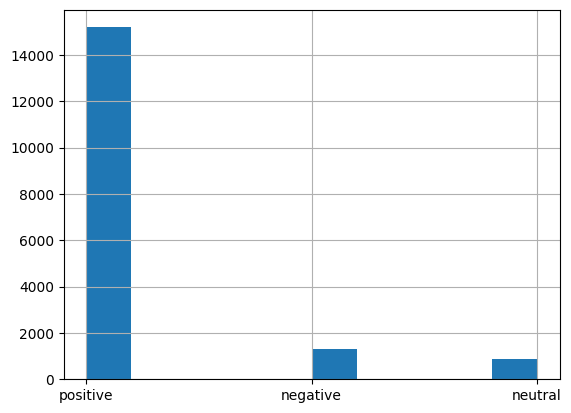

In [85]:
review["Sentiment Label"].hist()

## More Nuanced Sentiment Analysis

In [86]:
from transformers import pipeline

# Load the emotion classification pipeline
emotion_classifier = pipeline("text-classification",
                              model="j-hartmann/emotion-english-distilroberta-base",
                              return_all_scores=False)

# Apply the model to cleaned reviews (use a sample for speed if needed)
review['Emotion'] = review['Cleaned Review'].apply(lambda x: emotion_classifier(x)[0]['label'])

# Preview result
print(review[['Cleaned Review', 'Emotion']].sample(5))


2025-04-23 13:13:55.002348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-23 13:13:55.584802: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 13:13:55.759506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-23 13:13:55.759536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

/home/farajay96/.pyenv/versions/lewagon/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (572 > 512). Running this sequence through the model will result in indexing errors


RuntimeError: The expanded size of the tensor (572) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 572].  Tensor sizes: [1, 514]